# ERA5 Q1 Compositing

## import package

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc

from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

from matplotlib import pyplot as plt

## Load data

In [2]:
# date compute (compositing date: 2006~2017)
## setting total period of ERA5 data
date_tot = pd.date_range(start='1979-01-01', periods=15706, freq='d')

date_str: int = np.where((date_tot.year==2006))[0][0] # 2006/01/01
date_trm: int = np.where((date_tot.year==2017))[0][-1] # 2017/12/31

with nc.Dataset('/work/b11209013/2024_Research/nstcCCKW/Q1/Q1Flt.nc', 'r') as f:
    time = f['time'][date_str:date_trm+1]
    lat = f['lat'][:]
    lon = f['lon'][:]
    lev = f['lev'][:]
    q1 = f['Q1'][date_str:date_trm+1]

ltime, llev, llat, llon = q1.shape

print(q1.shape)

(4383, 38, 60, 576)


## Vertical integral

In [ ]:
lev_df = np.diff(lev)[None, :, None, None]
q1_ave = (q1[:, :1]+q1[:, :-1]) / 2
q1_int = -np.sum(q1_ave * lev_df, axis=1) * 86400/2.5e6/9.8

plt.contourf(lon, lat, q1_int.mean(axis=0))

## Bandpass filter

### Setup condition

In [4]:
def is_within_region(wnm, frm, wnm_min, wnm_max, frm_min, frm_max, kel_sign=1):
    kel_curves = lambda ed, k: (86400/(2*np.pi*6.371e6))*np.sqrt(9.81*ed)*k
    
    return (
        (wnm > wnm_min) & (wnm < wnm_max) &
        (frm > kel_sign * frm_min) & (frm < kel_sign * frm_max) &
        (frm < kel_sign * kel_curves(90, wnm)) &
        (frm > kel_sign * kel_curves(8, wnm))
    )

wn = np.fft.fftfreq(llon, d = 1/llon).astype(int) # unit: None
fr = np.fft.fftfreq(ltime, d = 1/4) # unit: CPD

wnm, frm = np.meshgrid(wn, fr)

cond1 = is_within_region(
    wnm, frm,
    wnm_min=1, wnm_max=14,
    frm_min=1/20, frm_max=1/2.5
)

cond2 = is_within_region(
    wnm, frm,
    wnm_min=-14, wnm_max=-1,
    frm_min=1/20, frm_max=1/2.5,
    kel_sign=-1
)

### Apply FFT on q1_int along latitude

In [5]:
def fft2(data):
    fft = np.array([np.fft.fft(data[i, :]) for i in range(data.shape[0])])
    fft = np.array([np.fft.ifft(fft[:, i]) for i in range(data.shape[1])]).T
    return fft


data_fft = np.stack([
    fft2(q1_int[:, i, :])
    for i in range(llat)
], axis=1)

### Bandpass filter

In [7]:
def ifft2(data):
    ifft = np.array([np.fft.ifft(data[:, i]) for i in range(data.shape[1])]).T
    ifft = np.array([np.fft.ifft(ifft[i, :]) for i in range(data.shape[0])])
    return ifft

mask = np.where(cond1 | cond2, 1, 0)



data_kel = np.stack([
    ifft2(mask * data_fft[:, i, :])
    for i in range(llat)
], axis=1)

print(data_kel)

[[[-5.41279638e-06-8.80224165e-05j -6.11139507e-06-8.41519017e-05j
   -7.29587710e-06-8.06879065e-05j ... -6.72614012e-06-1.01419187e-04j
   -5.67954573e-06-9.67272936e-05j -5.25377314e-06-9.22371051e-05j]
  [-1.13522436e-05-9.72650809e-05j -1.23959782e-05-9.54973588e-05j
   -1.36976584e-05-9.42464344e-05j ... -1.04463146e-05-1.05209905e-04j
   -1.03166099e-05-1.02175439e-04j -1.06375938e-05-9.95078751e-05j]
  [ 9.50159085e-06-1.04865685e-04j  1.15614923e-05-1.03696187e-04j
    1.35667776e-05-1.02572494e-04j ...  2.90067072e-06-1.08619483e-04j
    5.18036676e-06-1.07330804e-04j  7.37763332e-06-1.06078296e-04j]
  ...
  [ 1.04128259e-04+1.04598600e-04j  9.57096108e-05+1.12846990e-04j
    8.63862016e-05+1.20317164e-04j ...  1.23361259e-04+7.63566856e-05j
    1.17998886e-04+8.62312136e-05j  1.11575438e-04+9.56865784e-05j]
  [ 8.89253115e-05+9.77045974e-05j  8.05795302e-05+1.04052066e-04j
    7.15396677e-05+1.09628688e-04j ...  1.09202592e-04+7.49694164e-05j
    1.03284628e-04+8.30652895e-0

## Compute and Plot variance

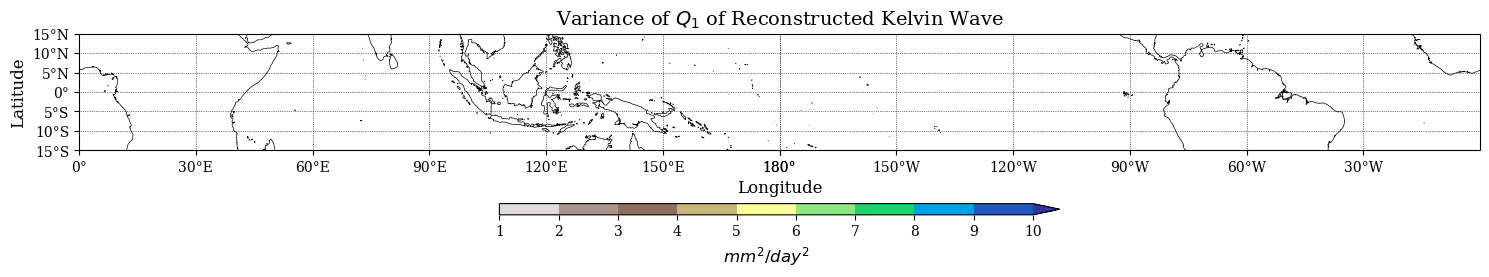

In [ ]:
kel_var = data_kel.var(axis=0)

plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(
    1,
    1,
    figsize=(15, 4),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)

ax.coastlines(linewidth=0.5)
ax.set_extent([-180, 180, -15, 15], crs=ccrs.PlateCarree())

c = ax.contourf(
    lon, lat, kel_var, transform=ccrs.PlateCarree(), cmap="terrain_r", extend="max",
    levels=np.linspace(1, 10, 10)
)
ax.set_xticks(np.linspace(-180, 180, 13), crs=ccrs.PlateCarree())
ax.set_yticks(np.linspace(-15, 15, 7), crs=ccrs.PlateCarree())

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title(r"Variance of $Q_1$ of Reconstructed Kelvin Wave")
ax.grid(color="black", linestyle=":", linewidth=0.5)
cbar = plt.colorbar(
    c, ax=ax, orientation="horizontal", label=r"$mm^2/day^2$", shrink=0.4, aspect=50
)
cbar.set_ticks(np.linspace(1, 10, 10))
plt.tight_layout()
plt.savefig('kel_var.png', dpi=300)
plt.show()